In [1]:
import os
import h5py    
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
import nrrd
from tifffile import tifffile
import json
from pprint import pprint
import math

In [2]:
filepath='/net/birdstore/Vessel/WBIM/Acquisition/LifeCanvas/003_20240209/00005/Scan/00060_00089/00000/tile.h5'

In [3]:
if os.path.exists(filepath):
    f = h5py.File(filepath, 'r')
    for key in f.keys():
        print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
        print(type(f[key])) # get the object type: usually group or dataset

    #Get the HDF5 group; key needs to be a group name from above
    group = f['CH1']
    print(type(group))
    #Checkout what keys are inside that group.
    for key in group.keys():
        print(key)
    data = group['raw'][()]
    print(f'dtype={data.dtype} shape={data.shape}')


In [4]:
if os.path.exists(filepath):
    plt.rcParams["figure.figsize"] = [14, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.imshow(data[125,:,:], cmap='seismic')
    #plt.show()

In [5]:
#filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_CMUrun2/tile_10.nrrd'
filepath = '/home/eddyod/programming/ITKMontage/examples/SampleData_DzZ_T1/tile_10.nrrd'
if os.path.exists(filepath):
    data, header = nrrd.read(filepath)
    print(data.dtype, readdata.shape)

In [6]:
# numpy is z,y,x, rows, columns
# matlab data is in [y, x, z] coordinates. 
# identify TIFF x=102, y=154 with 250 files
dirpath = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/layers/00001/tif'
filepath = os.path.join(dirpath, '00063_00096.tif')
if os.path.exists(filepath):
    data = tifffile.imread(filepath)
    #data = np.swapaxes(data, 0, 2)
    #data = np.swapaxes(data, 0, 1)
    print(data.dtype, data.shape, data.ndim)

uint16 (250, 154, 102) 3


In [7]:
if os.path.exists(filepath):
    arr = data[0,:,:]
    arr.dtype, arr.shape, arr.ndim

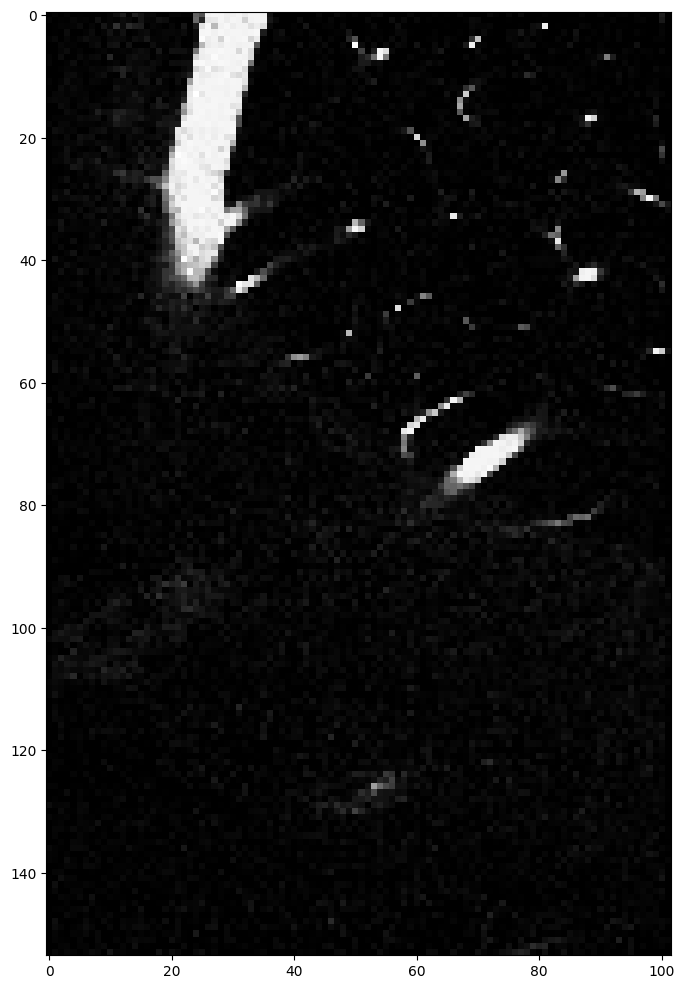

In [8]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.autolayout"] = True
plt.imshow(data[125,:,:], cmap='gray')

In [9]:
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK20230126-003/preps/layers/00001'
infopath = os.path.join(INPUT, 'info')
infos = sorted(os.listdir(infopath))
print(f'found {len(infos)} info.json files')

found 85 info.json files


In [10]:
bbox_mmxx_um = []
bbox_mmxx_pxl = []
layer_z_um = []
stitch_tiles = []
for file in sorted(infos):
    inpath = os.path.join(infopath, file)
    with open(inpath) as json_data:
        d = json.load(json_data)
        stitch_tiles.append(d)
        json_data.close()
        print('Box size of ', file, end="\t")
        #print(d['tile_mmxx_pxl'])
        dl = d['tile_mmxx_pxl']
        y_min, x_min, y_max, x_max = dl
        height = y_max - y_min
        width = x_max - x_min
        print(f'height={height}, width={width}')
        #print(dl)
        bbox_mmxx_um.append(d['tile_mmxx_um'])
        bbox_mmxx_pxl.append(d['tile_mmxx_pxl'])
        layer_z_um.append(d['layer_z_um'])

# set to np arrays
bbox_mmxx_um = np.array(bbox_mmxx_um)


Box size of  00059_00096.json	height=1535, width=1023
Box size of  00059_00097.json	height=1535, width=1023
Box size of  00059_00098.json	height=1535, width=1023
Box size of  00059_00099.json	height=1535, width=1023
Box size of  00060_00093.json	height=1535, width=1023
Box size of  00060_00094.json	height=1535, width=1023
Box size of  00060_00095.json	height=1535, width=1023
Box size of  00060_00096.json	height=1535, width=1023
Box size of  00060_00097.json	height=1535, width=1023
Box size of  00060_00098.json	height=1535, width=1023
Box size of  00060_00099.json	height=1535, width=1023
Box size of  00060_00100.json	height=1535, width=1023
Box size of  00060_00101.json	height=1535, width=1023
Box size of  00061_00091.json	height=1535, width=1023
Box size of  00061_00092.json	height=1535, width=1023
Box size of  00061_00093.json	height=1535, width=1023
Box size of  00061_00094.json	height=1535, width=1023
Box size of  00061_00095.json	height=1535, width=1023
Box size of  00061_00096.jso

1. layer_z_um is the z position of the first plane in micrometer. 
2. tile_mmxx_pxl is the bounding box of the 2D image [y_min, x_min, y_max, x_max] in pixel.

In [22]:
TIFPATH = os.path.join(INPUT, 'tif')
tiles = sorted(os.listdir(TIFPATH))
# Parameters
scaling_factor = 10
stitch_voxel_size_um = [0.375*scaling_factor, 0.375*scaling_factor, 1];
stack_size_um = stitch_tiles[0]['stack_size_um'];
print('stack_size_um', stack_size_um)
stack_size = stitch_tiles[0]['stack_size'];
ds_stack_size = [round(stack/stitch) for stack,stitch in zip(stack_size_um, stitch_voxel_size_um)]
print('ds_stack_size', ds_stack_size)


vol_bbox_z_mx_um = [56770, 56770, 249]
vol_bbox_mm_um = np.min(bbox_mmxx_um,0)[0:2].tolist()
vol_bbox_xx_um = np.max(bbox_mmxx_um,0)[2:4].tolist()
vol_bbox_mm_um.append(vol_bbox_z_mx_um[0])
vol_bbox_xx_um.append(vol_bbox_z_mx_um[1])
print('vol_bbox_mm_um', vol_bbox_mm_um)
print('vol_bbox_xx_um', vol_bbox_xx_um)

vol_bbox_ll_um = [a_i - b_i for a_i, b_i in zip(vol_bbox_xx_um, vol_bbox_mm_um)]
vol_bbox_ll_um = [a+1 for a in vol_bbox_ll_um]

print('vol_bbox_ll_um', vol_bbox_ll_um)
ds_bbox_ll = (np.array(vol_bbox_ll_um) / stitch_voxel_size_um)
ds_bbox_ll = [math.ceil(a) for a  in ds_bbox_ll]
#ds_bbox_ll = (np.array(vol_bbox_ll_um) / stitch_voxel_size_um)
ds_bbox_ll[2] = 250
print('ds_bbox_ll', ds_bbox_ll)
#print(f'vol_bbox_xx_um - vol_bbox_mm_um = {np.array(vol_bbox_xx_um) - np.array(vol_bbox_mm_um)}')


stack_size_um [576, 384, 250]
ds_stack_size [154, 102, 250]
vol_bbox_mm_um [32103.375, 32173.875, 56770]
vol_bbox_xx_um [37107.0, 37257.0, 56770]
vol_bbox_ll_um [5004.625, 5084.125, 1]
ds_bbox_ll [1335, 1356, 250]


In [12]:
0.325 * 32

10.4

In [26]:
# properties are in [y, x, z] coordinates. 
# numpy is [z,y,x]
ds_bbox_ll = [250, 1335, 1356]
assert len(infos) == len(tiles), "Error, number of tiles does not equal number of json files"
tmp_stitch_data = np.zeros(ds_bbox_ll, dtype=np.uint16)
print(f'Big box shape={tmp_stitch_data.shape}')

smaller_stitch = stitch_tiles[0:5]
smaller_tile = tiles[0:5]


for info,tile in zip(stitch_tiles, tiles):
    tifpath = os.path.join(TIFPATH, tile)
    tif = io.imread(tifpath)
    #tif = np.swapaxes(tif, 0, 2)
    #tif = np.swapaxes(tif, 0, 1)
    
    tmp_tile_bbox_mm_um = info['tile_mmxx_um'][:2]
    tmp_tile_bbox_mm_um.append(info['layer_z_um'])
    tmp_tile_bbox_ll_um = info['tile_mmll_um'][2:]
    tmp_tile_bbox_ll_um.append(info['stack_size_um'][2])
    tmp_tile_ll_ds_pxl = [round(bbox/voxel) for bbox,voxel in zip(tmp_tile_bbox_ll_um, stitch_voxel_size_um)]
    print(f'TIF shape= {tif.shape}', end="\t" )
    print('bounding box', tmp_tile_ll_ds_pxl, end="\t")
    
    # Local bounding box 
    tmp_local_bbox_um = [a_i - b_i for a_i, b_i in zip(tmp_tile_bbox_mm_um, vol_bbox_mm_um)]
    #tmp_local_bbox_mm_ds_pxl = round(tmp_local_bbox_um ./ stitch_voxel_size_um);
    tmp_local_bbox_mm_ds_pxl = [round(a/b) for a,b in zip(tmp_local_bbox_um, stitch_voxel_size_um)]
    #print(tmp_local_bbox_mm_ds_pxl)
    start_row = tmp_local_bbox_mm_ds_pxl[0]
    start_col = tmp_local_bbox_mm_ds_pxl[1]
    end_row = tif.shape[1] + start_row
    end_col = tif.shape[2] + start_col
    print(start_row, end_row, start_col, end_col)
    tmp_stitch_data[0:, start_row:end_row, start_col:end_col] += tif
    
    continue
    # Deal with edge: 
    tmp_local_bbox_mm_ds_pxl = np.max(tmp_local_bbox_mm_ds_pxl, axis=0)
    # tmp_local_bbox_xx_ds_pxl = tmp_local_bbox_mm_ds_pxl + tmp_tile_ll_ds_pxl - 1;

    tmp_local_bbox_xx_ds_pxl = [a + tmp_local_bbox_mm_ds_pxl for a in tmp_tile_ll_ds_pxl]
    tmp_local_bbox_xx_ds_pxl = [a-1 for a in tmp_local_bbox_xx_ds_pxl]

    # Max - rendering
    """
    tmp_stitch_data(tmp_local_bbox_mm_ds_pxl[0] : tmp_local_bbox_xx_ds_pxl[0], 
        tmp_local_bbox_mm_ds_pxl[1] : tmp_local_bbox_xx_ds_pxl[1], 
        tmp_local_bbox_mm_ds_pxl[2] : tmp_local_bbox_xx_ds_pxl[2]) = max(tmp_stitch_data(
        tmp_local_bbox_mm_ds_pxl[0] : tmp_local_bbox_xx_ds_pxl[0], 
        tmp_local_bbox_mm_ds_pxl[1] : tmp_local_bbox_xx_ds_pxl[1], 
        tmp_local_bbox_mm_ds_pxl[2] : tmp_local_bbox_xx_ds_pxl[2]), tmp_tile_data);
    """
outpath = '/home/eddyod/tmp/stitched.tif'
#tmp_stitch_data = np.swapaxes(tmp_stitch_data, 0, 2)

io.imsave(outpath, tmp_stitch_data)
print(f'dtype={tmp_stitch_data.dtype} shape={tmp_stitch_data.shape}')
print('saved', outpath)

Big box shape=(250, 1335, 1356)
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	0 154 578 680
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	0 154 675 777
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	0 154 771 873
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	0 154 868 970
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 289 391
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 386 488
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 482 584
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 578 680
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 675 777
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 771 873
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 868 970
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 964 1066
TIF shape= (250, 154, 102)	bounding box [154, 102, 250]	148 302 1060 1162
TIF shape= (250, 154, 102)	bounding b

/tmp/ipykernel_446457/2617657462.py:58: UserWarning: /home/eddyod/tmp/stitched.tif is a low contrast image
  io.imsave(outpath, tmp_stitch_data)


dtype=uint16 shape=(250, 1335, 1356)
saved /home/eddyod/tmp/stitched.tif
